In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pyfm import pylibfm
from fastFM import als
import scipy
import itertools
import pickle

# sklearn lib
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
% matplotlib inline

/Users/apple/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
amazon = pd.read_csv("no_outlier_data.csv")
class_desc = pd.read_csv("description.csv")
with open('cluster_index.pickle', 'rb') as handle:
    kcluster = pickle.load(handle)

In [3]:
def format_data(df, users_name, items_name, col, rename=[]):
    df = df[col]
    users = sorted(df[users_name].unique().tolist())
    items = sorted(df[items_name].unique().tolist())
    if rename:
        df = df.rename(index=str, columns=dict(zip(col, rename)))
    return users, items, df.to_dict(orient="records")

## Preprocessing

In [4]:
def preprocess(df, users_name, items_name, col, rename=[]):
    # Recevie sorted users items list and format data [{users:, items:, rating:}]
    users, items, data = format_data(df, users_name, items_name, col=col, rename=rename)
    
    # Vectorize and transform to csr_matrix
    dv = DictVectorizer()
    matrix = dv.fit_transform(data).toarray()
    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(matrix[:,1:], matrix[:,:1], test_size=0.2)
    x_train = scipy.sparse.csr_matrix(x_train)
    x_test = scipy.sparse.csr_matrix(x_test)
    y_train = y_train.T[0]
    y_test = y_test.T[0]
    return users, items, x_train, x_test, y_train, y_test

## Factorization Machine

In [95]:
def my_FM(x_train, y_train, x_test, y_test, k):
    # FM process
    fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=k, l2_reg_w=0.1, l2_reg_V=0.5)
    fm.fit(x_train, y_train)
    
    # Prediction
    y_pred = fm.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = round(100*accuracy_score((y_test>3.5).astype("int"),(y_pred>3.5).astype("int")),2)
    auc = round(100*roc_auc_score((y_test>3.5).astype("int"),(y_pred>3.5).astype("int")),2)
    
    print("FM MSE: %.4f" % mse)
    print("FM ACC: %s％" % acc)
    print("FM AUC: %s％" % auc)
    
    return fm, mse, acc, auc

## Post-processing

In [6]:
def fill_prediction_matrix(users, items, fm):
    pairs = [{"1_user": user, "2_item": item} for (user, item) in itertools.product(users, items)]
    
    dv = DictVectorizer()
    relation_matrix = scipy.sparse.csr_matrix(dv.fit_transform(pairs))
    
    pred = fm.predict(relation_matrix)
    return pred, pairs

# Main: In-Category Prediction

In [7]:
def main(df, kcluster):
    RES, MSE, ACC, AUC = dict(), dict(), dict(), dict()
    for key in kcluster:
        print("Cluster: %s" % key)
        cluster_item = class_desc.iloc[kcluster[key]]['asin'].values.tolist()
        table = df.loc[df['asin'].isin(cluster_item)][['asin', 'reviewer', 'star_rating']]
        users, items, x_train, x_test, y_train, y_test = preprocess(table, 'reviewer', 'asin', 
                                                    ["asin", "reviewer", "star_rating"], 
                                                    rename=["2_item", "1_user", "0_rating"])
        try:
            fm, mse, acc, auc = my_FM(x_train, y_train, x_test, y_test, 2)
            pred, pairs = fill_prediction_matrix(users, items, fm)
            for i, p in enumerate(pred):
                p = 1 if p < 1 else 5 if p > 5 else round(p, 4)
                pairs[i]["0_rating"] = p
            RES[key] = pd.DataFrame(data=pairs)
        except:
            RES[key] = np.nan
            mse, acc, auc = np.nan, np.nan, np.nan

        MSE[key] = mse
        ACC[key] = acc
        AUC[key] = auc
        print("\n")
    return RES, MSE, ACC, AUC

In [27]:
RES, MSE, ACC, AUC = main(amazon, kcluster)

Cluster: 0
FM MSE: 1.8393
FM ACC: 69.72％
FM AUC: 54.61％


Cluster: 1
FM MSE: 1.5499
FM ACC: 72.26％
FM AUC: 71.66％


Cluster: 2
FM MSE: 1.5892
FM ACC: 68.15％
FM AUC: 61.82％


Cluster: 3
FM MSE: 1.5823
FM ACC: 63.37％
FM AUC: 56.92％


Cluster: 4
FM MSE: 1.7580
FM ACC: 70.02％
FM AUC: 59.61％


Cluster: 5
FM MSE: 1.8832
FM ACC: 72.27％
FM AUC: 66.09％


Cluster: 6
FM MSE: 1.6833
FM ACC: 75.1％
FM AUC: 57.55％


Cluster: 7
FM MSE: 1.8129
FM ACC: 78.08％
FM AUC: 63.11％


Cluster: 8
FM MSE: 1.4807
FM ACC: 77.41％
FM AUC: 55.57％


Cluster: 9
FM MSE: 0.8579
FM ACC: 88.58％
FM AUC: 56.55％


Cluster: 10
FM MSE: 1.5754
FM ACC: 72.34％
FM AUC: 56.11％


Cluster: 11
FM MSE: 1.8206
FM ACC: 74.93％
FM AUC: 65.2％


Cluster: 12
FM MSE: 1.9080
FM ACC: 60.33％
FM AUC: 59.42％


Cluster: 13
FM MSE: 1.7191
FM ACC: 61.69％
FM AUC: 63.0％


Cluster: 14
FM MSE: 1.1622
FM ACC: 84.54％
FM AUC: 53.17％


Cluster: 15
FM MSE: 1.5558
FM ACC: 72.14％
FM AUC: 55.84％


Cluster: 16
FM MSE: 0.8661
FM ACC: 92.34％
FM AUC: 56.92％


Cluster: 1

In [28]:
df_concat = pd.concat(RES)
pred_table = pd.pivot_table(df_concat, index="1_user", columns="2_item", values="0_rating")

In [84]:
print("Mean RMSE: %.4f" % (sum([v**0.5 for v in MSE.values()])/len(MSE)))
print("Mean ACC: %.4f％" % (sum(ACC.values())/len(ACC)))
print("Mean AUC: %.4f％" % (sum(AUC.values())/len(AUC)))

Mean RMSE: 1.2914
Mean ACC: 72.7152％
Mean AUC: 60.2915％


In [ ]:
pred_table.to_csv("in_category_prediction_matrix.csv", encoding='utf-8')

In [82]:
df_concat.to_csv("in_category_prediction_tuple.csv", encoding='utf-8')

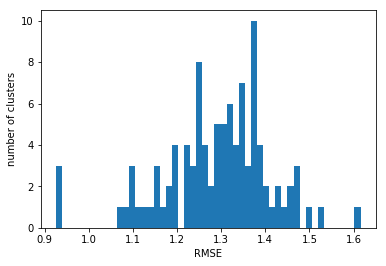

In [85]:
plt.hist([v**0.5 for v in MSE.values()], bins=50)
plt.ylabel('number of clusters')
plt.xlabel('RMSE')

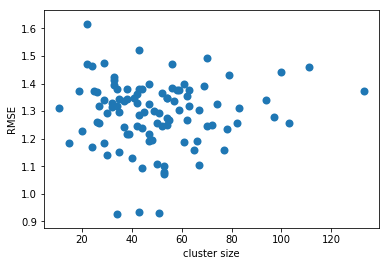

In [86]:
x_axis = [len(kcluster[i]) for i in range(100)]
y_axis = [v**0.5 for v in MSE.values()]
plt.scatter(x_axis,y_axis,linewidth=2)
plt.ylabel('RMSE')
plt.xlabel('cluster size')

## In-category Hyper Parameter Tuning

In [98]:
def inCategory_hyparamTunning(df, kcluster):
    MSE, ACC, AUC = {0:[],32:[], 55:[]},{0:[],32:[], 55:[]},{0:[],32:[], 55:[]}
    for key in [0, 32, 55]:
        print("Cluster: %s" % key)
        cluster_item = class_desc.iloc[kcluster[key]]['asin'].values.tolist()
        table = df.loc[df['asin'].isin(cluster_item)][['asin', 'reviewer', 'star_rating']]
        users, items, x_train, x_test, y_train, y_test = preprocess(table, 'reviewer', 'asin', 
                                                    ["asin", "reviewer", "star_rating"], 
                                                    rename=["2_item", "1_user", "0_rating"])
    
        for k in range(2, 11):
            fm, mse, acc, auc = my_FM(x_train, y_train, x_test, y_test, k)
            MSE[key].append(mse)
            ACC[key].append(acc)
            AUC[key].append(auc)
            print("\n")
        print("\n")
    return MSE, ACC, AUC

In [99]:
hiMSE, hiACC, hiAUC = inCategory_hyparamTunning(amazon, kcluster)

Cluster: 0
FM MSE: 1.9159
FM ACC: 71.1％
FM AUC: 57.86％


FM MSE: 1.8799
FM ACC: 70.41％
FM AUC: 58.4％


FM MSE: 1.8913
FM ACC: 70.64％
FM AUC: 58.81％


FM MSE: 1.8913
FM ACC: 70.41％
FM AUC: 58.4％


FM MSE: 1.8909
FM ACC: 70.41％
FM AUC: 58.4％


FM MSE: 1.8911
FM ACC: 70.18％
FM AUC: 57.99％


FM MSE: 1.8914
FM ACC: 70.18％
FM AUC: 57.99％


FM MSE: 1.8914
FM ACC: 70.18％
FM AUC: 57.99％


FM MSE: 1.8911
FM ACC: 70.18％
FM AUC: 57.99％




Cluster: 32
FM MSE: 2.0115
FM ACC: 66.72％
FM AUC: 60.19％


FM MSE: 1.9789
FM ACC: 67.38％
FM AUC: 63.69％


FM MSE: 1.9755
FM ACC: 67.22％
FM AUC: 63.67％


FM MSE: 1.9759
FM ACC: 67.05％
FM AUC: 63.55％


FM MSE: 1.9734
FM ACC: 67.05％
FM AUC: 63.55％


FM MSE: 1.9741
FM ACC: 67.05％
FM AUC: 63.55％


FM MSE: 1.9740
FM ACC: 67.05％
FM AUC: 63.55％


FM MSE: 1.9729
FM ACC: 67.05％
FM AUC: 63.55％


FM MSE: 1.9739
FM ACC: 67.05％
FM AUC: 63.55％




Cluster: 55
FM MSE: 1.5540
FM ACC: 76.9％
FM AUC: 60.6％


FM MSE: 1.5505
FM ACC: 76.6％
FM AUC: 60.0％


FM MSE: 1.5503
FM ACC: 76.6％


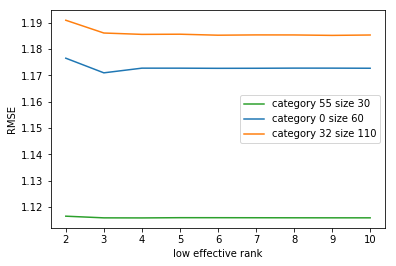

In [111]:
for key in [0, 32, 55]:
    hiMSE[key] = [v**0.5 for v in hiMSE[key]]

x_axis = list(range(2,11))
hi0, = plt.plot(x_axis,hiMSE[0])
hi32, = plt.plot(x_axis,hiMSE[32])
hi55, = plt.plot(x_axis,hiMSE[55])
plt.ylabel("RMSE")
plt.xlabel("low effective rank")
plt.legend([hi55, hi0, hi32 ], ["category 55 size 30", "category 0 size 60", "category 32 size 110"])

## cross-Category Predict

In [8]:
df_101 = pd.read_csv("df_101.csv")

In [125]:
def crossCategoryPredict(df):
    RES, MSE, ACC, AUC = dict(), dict(), dict(), dict()
    melt = pd.melt(df, id_vars=["cluster"])
    melt = melt[melt["value"]!=0]
    
    size = 30000
    count = melt.shape[0]//size
    for key in range(count):
        start = key * size
        end = (key+1)*size if key+1 < count else melt.shape[0]
        print("%s to %s" % (start, end))
        
#         col = ["cluster"] + user_df.columns[start:end].tolist()
#         df_part = df[col]
#         melt = pd.melt(df_part, id_vars=['cluster']) # [cluster, variable, value]
        part = melt[start:end]
        users, items, x_train, x_test, y_train, y_test = preprocess(part, 'variable', 'cluster', 
                                                    ["cluster", "variable", "value"], 
                                                    rename=["2_item", "1_user", "0_rating"])
        try:
            fm, mse, acc, auc = my_FM(x_train, y_train, x_test, y_test)
            pred, pairs = fill_prediction_matrix(users, items, fm)
            for i, p in enumerate(pred):
                p = 1 if p < 1 else 5 if p > 5 else round(p, 4)
                pairs[i]["0_rating"] = p
            RES[key] = pd.DataFrame(data=pairs)
        except:
            RES[key] = np.nan
            mse, acc, auc = np.nan, np.nan, np.nan

        MSE[key] = mse
        ACC[key] = acc
        AUC[key] = auc
        print("\n")
    return RES, MSE, ACC, AUC

In [17]:
iRES, iMSE, iACC, iAUC = crossCategoryPredict(df_101)

0 to 30000
FM MSE: 2.7277
FM ACC: 69.2％
FM AUC: 58.26％


30000 to 60000
FM MSE: 2.9408
FM ACC: 68.03％
FM AUC: 56.65％


60000 to 90000
FM MSE: 2.7700
FM ACC: 68.48％
FM AUC: 57.37％


90000 to 120000
FM MSE: 2.7279
FM ACC: 68.32％
FM AUC: 57.97％


120000 to 150000
FM MSE: 2.8882
FM ACC: 68.12％
FM AUC: 57.6％


150000 to 180000
FM MSE: 2.8548
FM ACC: 67.63％
FM AUC: 56.44％


180000 to 210000
FM MSE: 2.6850
FM ACC: 69.12％
FM AUC: 59.35％


210000 to 251908
FM MSE: 2.8976
FM ACC: 67.96％
FM AUC: 58.32％




In [19]:
idf_concat = pd.concat(iRES)
ipred_table = pd.pivot_table(idf_concat, index="2_item", columns="1_user", values="0_rating")

In [31]:
ipred_table.head()

1_user,A00039763E5V43M02Z3YZ,A00111163LLS4KLYZXNZL,A002359833QJM7OQHCXWY,A00236702NOP1FKXVRFN3,A0026556YRYONJ90H57Z,A00281722IA12Z7XNGMJV,A0037670NPLI11RBWYFA,A0038872349TB5N0JHQQW,A004257029HNEB0RA4Z6V,A00440181FM3TJMYVT608,...,AZZIR7GU8SMIR,AZZJ1H7DM2UQD,AZZJG13YQANEA,AZZN34VU2X737,AZZN3MTTZHA74,AZZNEMLU7N9ET,AZZNWOFUDH8S2,AZZPCFDGCFI0D,AZZQ97SNW14J1,AZZYKX2KZ0Q82
2_item,,,,,,,,,,,,,,,,,,,,,
cluster0,3.9210,5.0000,4.0198,3.9467,4.1705,3.7354,3.5342,2.8198,4.7184,3.3680,...,4.3459,3.3483,2.3321,5.0000,3.5314,3.0465,5.0000,4.9458,5.0000,4.0391
cluster1,3.6583,4.6082,2.1124,3.6163,4.7702,4.0251,1.5006,3.6562,4.8558,3.8989,...,4.5855,3.3113,2.4166,4.7606,2.8526,3.2133,5.0000,5.0000,5.0000,4.0021
cluster10,4.0483,5.0000,3.9805,4.0668,4.3816,3.9170,3.4917,3.0512,4.8623,3.5848,...,3.8291,5.0000,5.0000,4.6357,4.4360,5.0000,1.9949,3.9119,4.0004,3.9979
cluster11,3.8421,3.6377,5.0000,3.8893,2.9910,3.0115,5.0000,1.0762,2.0083,3.4596,...,5.0000,4.4693,4.4757,3.7811,1.7648,4.8605,4.5037,4.9886,4.9834,4.0283
cluster12,3.8788,3.9154,3.4663,3.8579,4.1632,3.7560,3.5623,2.6450,3.2595,4.1574,...,4.6816,3.6847,3.2474,4.0458,2.0196,3.8620,4.8169,4.8838,4.9971,3.8308


In [90]:
print("Mean iRMSE: %.4f" % (sum([v**0.5 for v in iMSE.values()])/len(iMSE)))
print("Mean iACC: %.4f％" % (sum(iACC.values())/len(iACC)))
print("Mean iAUC: %.4f％" % (sum(iAUC.values())/len(iAUC)))

Mean iRMSE: 1.6765
Mean iACC: 68.3575％
Mean iAUC: 57.7450％


In [ ]:
ipred_table.to_csv("cross_category_prediction_matrix.csv", encoding='utf-8')

In [26]:
idf_concat.to_csv("cross_category_prediction_tuple.csv", encoding="utf-8")

## cross-category Hyper parameter tuning

In [121]:
def cross_hyperparamTuning(df):
    MSE, ACC, AUC = list(), list(), list()
    melt = pd.melt(df, id_vars=["cluster"])
    melt = melt[melt["value"]!=0]
    
    for k in range(2, 30):
        size = 30000
        count = melt.shape[0]//size
        tMSE, tACC, tAUC = list(), list(), list()
        for key in range(count):
            start = key * size
            end = (key+1)*size if key+1 < count else melt.shape[0]
            print("%s to %s" % (start, end))
            
            part = melt[start:end]
            users, items, x_train, x_test, y_train, y_test = preprocess(part, 'variable', 'cluster', 
                                                        ["cluster", "variable", "value"], 
                                                        rename=["2_item", "1_user", "0_rating"])
        
            fm, mse, acc, auc = my_FM(x_train, y_train, x_test, y_test, k)
            tMSE.append(mse)
            tACC.append(acc)
            tAUC.append(auc)
            print("\n")
        MSE.append(sum(tMSE)/len(tMSE))
        ACC.append(sum(tACC)/len(tACC))
        AUC.append(sum(tAUC)/len(tAUC))
        print("\n")
    return MSE, ACC, AUC

In [122]:
hcMSE, hcACC, hcAUC = cross_hyperparamTuning(df_101)

0 to 30000
FM MSE: 2.7985
FM ACC: 68.22％
FM AUC: 57.59％


30000 to 60000
FM MSE: 2.9225
FM ACC: 68.22％
FM AUC: 57.74％


60000 to 90000
FM MSE: 2.9288
FM ACC: 68.87％
FM AUC: 58.07％


90000 to 120000
FM MSE: 2.7041
FM ACC: 68.5％
FM AUC: 58.0％


120000 to 150000
FM MSE: 2.8180
FM ACC: 68.15％
FM AUC: 57.68％


150000 to 180000
FM MSE: 2.8422
FM ACC: 67.42％
FM AUC: 57.06％


180000 to 210000
FM MSE: 2.7771
FM ACC: 66.88％
FM AUC: 57.53％


210000 to 251908
FM MSE: 2.9215
FM ACC: 68.42％
FM AUC: 57.54％




0 to 30000
FM MSE: 2.6220
FM ACC: 68.68％
FM AUC: 57.83％


30000 to 60000
FM MSE: 2.7676
FM ACC: 67.42％
FM AUC: 56.46％


60000 to 90000
FM MSE: 2.5753
FM ACC: 68.47％
FM AUC: 56.83％


90000 to 120000
FM MSE: 2.5800
FM ACC: 69.38％
FM AUC: 59.16％


120000 to 150000
FM MSE: 2.6728
FM ACC: 69.7％
FM AUC: 58.57％


150000 to 180000
FM MSE: 2.5794
FM ACC: 68.98％
FM AUC: 57.76％


180000 to 210000
FM MSE: 2.8815
FM ACC: 68.02％
FM AUC: 57.85％


210000 to 251908
FM MSE: 2.7229
FM ACC: 67.05％
FM AUC: 56.35％



FM MSE: 1.7788
FM ACC: 71.3％
FM AUC: 57.76％


120000 to 150000
FM MSE: 1.7953
FM ACC: 71.5％
FM AUC: 58.92％


150000 to 180000
FM MSE: 1.7538
FM ACC: 71.65％
FM AUC: 57.75％


180000 to 210000
FM MSE: 1.7922
FM ACC: 71.47％
FM AUC: 58.95％


210000 to 251908
FM MSE: 1.8244
FM ACC: 71.49％
FM AUC: 57.47％




0 to 30000
FM MSE: 1.6838
FM ACC: 72.37％
FM AUC: 58.16％


30000 to 60000
FM MSE: 1.7551
FM ACC: 72.6％
FM AUC: 58.68％


60000 to 90000
FM MSE: 1.6972
FM ACC: 72.57％
FM AUC: 58.2％


90000 to 120000
FM MSE: 1.8027
FM ACC: 70.8％
FM AUC: 58.54％


120000 to 150000
FM MSE: 1.7623
FM ACC: 72.13％
FM AUC: 59.39％


150000 to 180000
FM MSE: 1.7410
FM ACC: 72.08％
FM AUC: 57.58％


180000 to 210000
FM MSE: 1.7428
FM ACC: 71.95％
FM AUC: 58.82％


210000 to 251908
FM MSE: 1.7483
FM ACC: 72.08％
FM AUC: 57.92％




0 to 30000
FM MSE: 1.6401
FM ACC: 72.68％
FM AUC: 58.8％


30000 to 60000
FM MSE: 1.7831
FM ACC: 72.42％
FM AUC: 58.55％


60000 to 90000
FM MSE: 1.6906
FM ACC: 72.27％
FM AUC: 58.23％


90000 to 120000


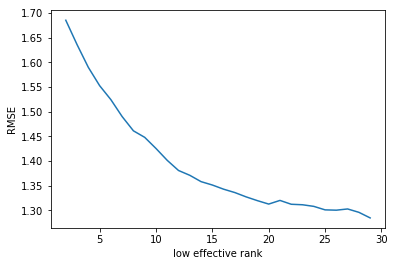

In [124]:
hcRMSE = [v**0.5 for v in hcMSE]

x_axis = list(range(2,30))
hi0, = plt.plot(x_axis,hcRMSE)
plt.ylabel("RMSE")
plt.xlabel("low effective rank")

# Hybrid Prediction

In [172]:
def inCatHybridPred(df_in, k):
    users, items, x_train, x_test, y_train, y_test = preprocess(df_in, 'reviewer', 'asin', 
                                                ["asin", "reviewer", "star_rating"], 
                                                rename=["2_item", "1_user", "0_rating"])
#     users, items, _, _, _, _ = preprocess(df_out, 'reviewer', 'asin', 
#                                                 ["asin", "reviewer", "star_rating"], 
#                                                 rename=["2_item", "1_user", "0_rating"])
    try:
        fm, MSE, ACC, AUC = my_FM(x_train, y_train, x_test, y_test, k)
        pred, pairs = fill_prediction_matrix(users, items, fm)
        for i, p in enumerate(pred):
            p = 1 if p < 1 else 5 if p > 5 else round(p, 4)
            pairs[i]["0_rating"] = p
        RES = pd.DataFrame(data=pairs)
    except:
        RES = np.nan
        MSE, ACC, AUC = np.nan, np.nan, np.nan

    return RES, MSE, ACC, AUC

In [127]:
inCatInput = pd.read_csv("Hybrid Input/train_in_categoty.csv", index_col="Unnamed: 0")
inCatOutput = pd.read_csv("Hybrid Input/test_in_categoty.csv", index_col="Unnamed: 0")

In [173]:
users, items, _, _, _, _ = preprocess(inCatOutput, 'reviewer', 'asin', 
                                      ["asin", "reviewer", "star_rating"], rename=["2_item", "1_user", "0_rating"])
inCat_df = pd.concat([inCatInput, inCatOutput])
hbi_RES, _, _, _ = inCatHybridPred(inCat_df, 3)

FM MSE: 1.5709
FM ACC: 69.37％
FM AUC: 57.31％


In [199]:
res = hbi_RES[hbi_RES['2_item'].isin(items)]
res = res[res['1_user'].isin(users)]
res = res.rename(index=str, columns={'1_user': 'reviewer', '2_item': "asin", "0_rating": "star_rating"})

In [227]:
pred = list()
for row in inCatOutput.itertuples():
    # row = [Index, asin, reviewer, star_rating]
    tmp = res[(res['asin'] == row[1]) & (res['reviewer'] == row[2])]
    pred.append(tmp["star_rating"][0])
inCatOutput["predicted rating"] = pred

In [229]:
inCatOutput.to_csv("./Hybrid Input/inCatOutput.csv", encoding="utf-8")

In [238]:
def crossCatHybridPred(df_in, k):
    RES, MSE, ACC, AUC = dict(), dict(), dict(), dict()
    
    size = 30000
    count = df_in.shape[0]//size
    for key in range(count):
        start = key * size
        end = (key+1)*size if key+1 < count else melt.shape[0]
        print("%s to %s" % (start, end))
        
        part = df_in[start:end]
        users, items, x_train, x_test, y_train, y_test = preprocess(part, 'reviewer', 'cluster', 
                                                    ["cluster", "reviewer", "rating"], 
                                                    rename=["2_item", "1_user", "0_rating"])
        try:
            fm, mse, acc, auc = my_FM(x_train, y_train, x_test, y_test, k)
            pred, pairs = fill_prediction_matrix(users, items, fm)
            for i, p in enumerate(pred):
                p = 1 if p < 1 else 5 if p > 5 else round(p, 4)
                pairs[i]["0_rating"] = p
            RES[key] = pd.DataFrame(data=pairs)
        except:
            RES[key] = np.nan
            mse, acc, auc = np.nan, np.nan, np.nan

        MSE[key] = mse
        ACC[key] = acc
        AUC[key] = auc
        print("\n")
    return RES, MSE, ACC, AUC

In [231]:
crossCatInput = pd.read_csv("Hybrid Input/train_cross_category.csv", index_col="Unnamed: 0").rename(index=str, columns={'asin': 'reviewer'})
crossCatOutput = pd.read_csv("Hybrid Input/test_cross_category.csv", index_col="Unnamed: 0").rename(index=str, columns={'asin': 'reviewer'})

In [239]:
users = crossCatOutput['reviewer'].unique().tolist()
items = crossCatOutput['cluster'].unique().tolist()
crossCat_df = pd.concat([crossCatInput, crossCatOutput])
hbc_RES, _, _, _ = crossCatHybridPred(crossCat_df, 3)

0 to 30000
FM MSE: 1.7795
FM ACC: 72.23％
FM AUC: 50.98％


30000 to 60000
FM MSE: 1.8569
FM ACC: 71.75％
FM AUC: 54.51％


60000 to 90000
FM MSE: 1.9308
FM ACC: 71.65％
FM AUC: 52.1％


90000 to 120000
FM MSE: 1.8339
FM ACC: 74.38％
FM AUC: 51.45％


120000 to 150000
FM MSE: 2.1568
FM ACC: 67.88％
FM AUC: 52.25％


150000 to 180000
FM MSE: 2.0101
FM ACC: 68.88％
FM AUC: 51.75％


180000 to 210000
FM MSE: 1.9559
FM ACC: 69.03％
FM AUC: 54.74％


210000 to 340314
FM MSE: 2.0156
FM ACC: 69.94％
FM AUC: 53.04％




In [252]:
res = pd.concat(hbc_RES.values())
res = res[res['2_item'].isin(items)]
res = res[res['1_user'].isin(users)]
res = res.rename(index=str, columns={'1_user': 'reviewer', '2_item': "cluster", "0_rating": "rating"})

In [ ]:
pred, i= list(), 0
for row in crossCatOutput.itertuples():
    print(i)
    # row = [Index, reviewer, rating, cluster]
    tmp = res[(res['cluster'] == row[3]) & (res['reviewer'] == row[1])]
    pred.append(tmp["rating"][0])
    i += 1
crossCatOutput["predicted rating"] = pred

In [260]:
crossCatOutput = crossCatOutput[['reviewer','cluster','rating','predicted rating']]

In [262]:
crossCatOutput.to_csv("./Hybrid Input/crossCatOutput.csv", encoding="utf-8")